# Results Summary

In [12]:
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import numpy as np
from itertools import product

In [2]:
sns.set_context('talk')

In [3]:
annotated_features = ['expanse', 'object', 
                 'agent distance', 'facingness', 'joint action', 
                 'communication', 'valence', 'arousal']
rois = ['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS', 'FFA', 'PPA']

## Vision Models

### Behavior

In [4]:
files = glob(f'../data/interim/VisionBehaviorEncoding/*.csv.gz')
files.sort(key=os.path.getmtime)
df = []
for file in files:
    df.append(pd.read_csv(file))
df = pd.concat(df)

In [5]:
def get_max_score(group, col='train_score'):
    return group.loc[group[col].idxmax()]

In [6]:
max_scores = df.groupby(['feature', 'model_uid']).apply(get_max_score).reset_index(drop=True)
rename_mapping = {orig: orig.replace('rating-', '').replace('_', ' ') for orig in max_scores.feature.unique()}
max_scores = pd.melt(max_scores, id_vars=["model_uid", "model_layer", "model_layer_index", "feature"], 
                    value_vars=["train_score", "test_score"], 
                    var_name="set", value_name="score")
max_scores['feature'] = max_scores['feature'].replace(rename_mapping)
max_scores['feature'] = pd.Categorical(max_scores['feature'], categories=annotated_features, ordered=True)
max_scores['set'] = max_scores['set'].replace({'train_score': 'train', 'test_score': 'test'})
max_scores['set'] = pd.Categorical(max_scores['set'], categories=['train', 'test'], ordered=True)

          feature  reliabilty
0         expanse    0.719483
1          object    0.928456
2  agent_distance    0.885451
3      facingness    0.957481
4    joint_action    0.768867
5   communication    0.762171
6         valence    0.747964
7         arousal    0.683388

/tmp/ipykernel_364818/793085878.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=40, ha='right')


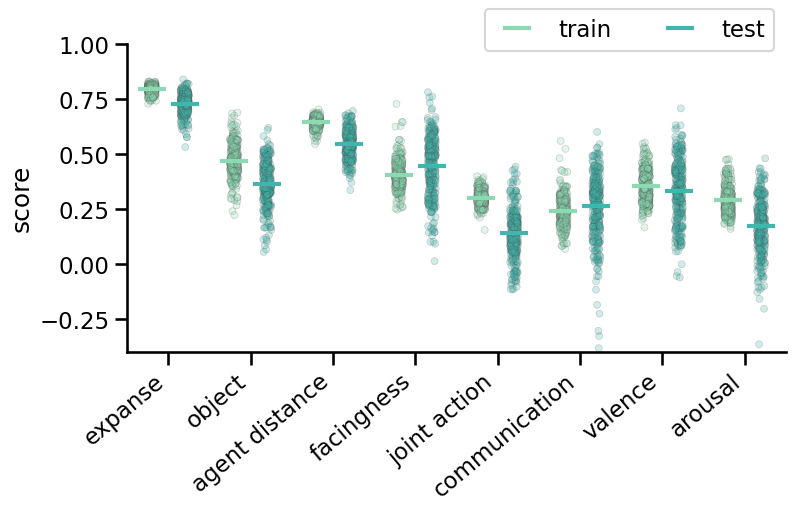

In [7]:
_, ax = plt.subplots(figsize=(8.5,4))
sns.set_palette('mako_r')
color = ['gray', 'gray', 'gray']

sns.stripplot(x='feature', y='score', hue='set', data=max_scores,
              ax=ax, dodge=True, jitter=True, linewidth=.5, alpha=0.25, zorder=0, legend=False)
sns.pointplot(x='feature', y='score', hue='set', data=max_scores,
               dodge=.4, linestyle="none", errorbar=None,
              marker="_", markersize=20, markeredgewidth=3, zorder=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xlabels = ax.get_xticklabels()
ax.set_xlabel('')
ax.set_ylim([-.4, 1])
ax.set_xticklabels(xlabels, rotation=40, ha='right')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.15),
          ncol=2, fancybox=True)

### Neural

In [27]:
# files = glob(f'../data/interim/VisionNeuralEncoding/grouped_average/*.pkl.gz')
# files += glob(f'../data/interim/VisionNeuralEncoding/grouped_stack/*.pkl.gz')
# df = []
# for file in files:
#     cur = pd.read_pickle(file)
#     cur.drop(columns=['r_null_dist', 'r_bootstrap_dist'], inplace=True)
#     if 'grouped_stack' in file:
#         cur['combine_method'] = 'stack'
#     else:
#         cur['combine_method'] = 'average'
#     df.append(cur)
# df = pd.concat(df)
# df['model_uid'] = df['model_uid'] + df['combine_method']

In [4]:
files = glob(f'../data/interim/VisionNeuralEncoding_old/*.csv.gz')
print(f'{len(files)} neural encoding models found')
df = []
for file in tqdm(files):
    cdf = pd.read_csv(file)
    df.append(cdf[cdf['roi_name'] != 'none'].reset_index(drop=True))
df = pd.concat(df).reset_index(drop=True)

328 neural encoding models found


100%|██████████| 328/328 [02:00<00:00,  2.73it/s]


In [5]:
max_scores = df.groupby(['subj_id', 'roi_name', 'model_uid']).mean(numeric_only=True).reset_index()
max_scores = max_scores.groupby(['roi_name', 'model_uid']).mean(numeric_only=True).reset_index()
max_scores = max_scores.loc[max_scores.roi_name.isin(rois)].reset_index(drop=True)
max_scores = pd.melt(max_scores, id_vars=["model_uid", "layer_index", "layer_relative_depth", "roi_name", "reliability"], 
                    value_vars=["train_score", "test_score"], 
                    var_name="set", value_name="score")
# max_scores['feature'] = max_scores['feature'].replace(rename_mapping)
max_scores['roi_name'] = pd.Categorical(max_scores['roi_name'], categories=rois, ordered=True)
max_scores['set'] = max_scores['set'].replace({'train_score': 'train', 'test_score': 'test'})
max_scores['set'] = pd.Categorical(max_scores['set'], categories=['train', 'test'], ordered=True)
max_scores['normalized_score'] = max_scores['score'] / max_scores['reliability']

In [14]:
model_uids_to_annotate = ['torchvision_alexnet_imagenet1k_v1', 'slip_vit_b_clip_yfcc15m']
model_uids_to_annotate += [max_scores[(max_scores.roi_name == 'pSTS') & (max_scores.set == 'test')].max()['model_uid']]
model_name_to_show = ['alexnet', 'clip']
model_name_to_show += [max_scores[(max_scores.roi_name == 'pSTS') & (max_scores.set == 'test')].max()['model_uid']]
rename_mapping = {key: val for key, val in zip(model_uids_to_annotate, model_name_to_show)}
offset_positions = [(-20,-25), (-15, 55), (15,70)]
offset_mapping = {key: val for key, val in zip(model_uids_to_annotate, offset_positions)}
annotation_roi = 'pSTS'
annotation_set = 'test'

/tmp/ipykernel_1514322/3215872031.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/tmp/ipykernel_1514322/3215872031.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, ha='center')
/tmp/ipykernel_1514322/3215872031.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],


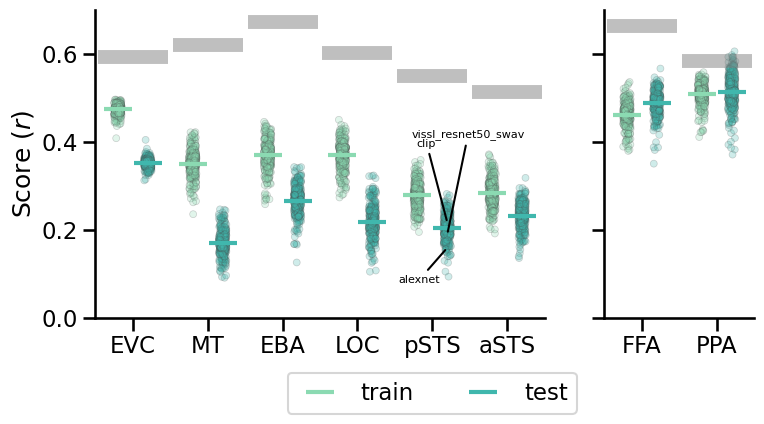

In [16]:
_, axes = plt.subplots(1, 2, figsize=(8.5,4), gridspec_kw={'width_ratios': [3, 1]},
                      sharey=True)
sns.set_palette('mako_r')
color = ['gray', 'gray', 'gray']
for i_ax, (ax, cur_rois) in enumerate(zip(axes, [['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS'], ['FFA', 'PPA']])):
    cur_scores = max_scores.loc[max_scores.roi_name.isin(cur_rois)]
    cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
                                            categories=cur_rois, ordered=True)
    sns.stripplot(x='roi_name', y='score', hue='set', data=cur_scores,
                  ax=ax, dodge=True, jitter=True, linewidth=.5,
                  alpha=0.25, zorder=0, legend=False)
    strip_collections = ax.collections
    sns.pointplot(x='roi_name', y='reliability', data=cur_scores,
                  ax=ax, linestyle="none", errorbar=None, 
                  marker="_", markersize=50, markeredgewidth=10,
                  color='gray', alpha=.5, zorder=1)
    if i_ax == 0: 
        sns.pointplot(x='roi_name', y='score', hue='set', data=cur_scores,
                      ax=ax, legend=True, 
                      dodge=.4, linestyle="none", errorbar=None,
                      marker="_", markersize=20, markeredgewidth=3, zorder=1)
    else: 
        sns.pointplot(x='roi_name', y='score', hue='set', data=cur_scores,
                      ax=ax, legend=False,
                      dodge=.4, linestyle="none", errorbar=None,
                      marker="_", markersize=20, markeredgewidth=3, zorder=1)
    
    dodge_amount = 0.2  # Adjust based on your seaborn stripplot dodge parameter
    roi_positions = {roi: i for i, roi in enumerate(cur_rois)}
    if annotation_roi in cur_rois: 
        collection_names = list(product(cur_rois, ['train', 'test']))
        matching_index = [index for index, (roi, set_) in enumerate(collection_names) if roi == annotation_roi and set_ == annotation_set][0]
        stripplot_points = strip_collections[matching_index].get_offsets()
    # Loop through the DataFrame and annotate the points for select model_uids
    for _, row in cur_scores.iterrows():
        if (row['model_uid'] in model_uids_to_annotate and
            row['set'] == annotation_set and
            row['roi_name'] == annotation_roi):
            x_pos = roi_positions[row['roi_name']]
            if row['set'] == 'test':  # Adjust the dodge based on the 'set' value if necessary
                x_pos += dodge_amount
            else:
                x_pos -= dodge_amount

            # Find the closest point to the intended (x_pos, y_pos)
            y_pos = row['score']
            distances = np.sqrt((stripplot_points[:, 0] - x_pos)**2 + (stripplot_points[:, 1] - y_pos)**2)
            closest_point_idx = np.argmin(distances)
            closest_point = stripplot_points[closest_point_idx]

            ax.annotate(rename_mapping[row['model_uid']],
                        xy=closest_point,  # Use the closest stripplot point
                        xytext=offset_mapping[row['model_uid']],  # Offset for the annotation
                        textcoords='offset points',
                        ha='center',
                        fontsize=8,  # Adjust the text size if needed
                        arrowprops=dict(arrowstyle="-", connectionstyle="arc3,rad=0"))
            
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels, ha='center')
    ax.set_xlabel('')
    ax.set_ylim([0, .7])
    if i_ax == 0: 
        ax.set_ylabel('Score ($r$)')
        ax.legend(loc='lower center', bbox_to_anchor=(0.75, -.35),
                  ncol=2, fancybox=True)

/tmp/ipykernel_2494636/908473346.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/tmp/ipykernel_2494636/908473346.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, ha='center')
/tmp/ipykernel_2494636/908473346.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/tm

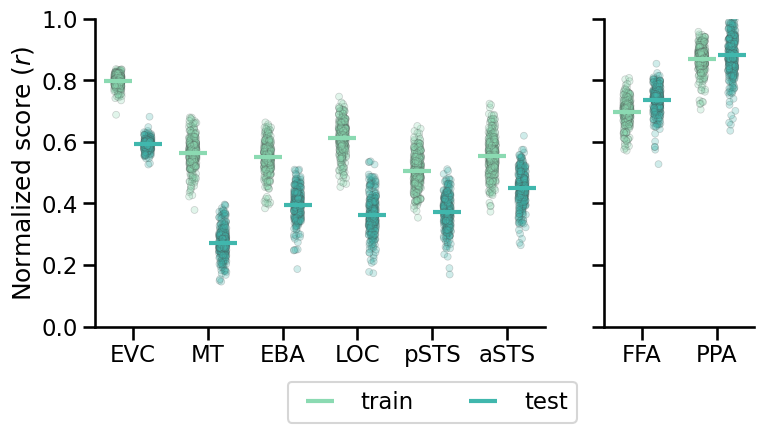

In [81]:
_, axes = plt.subplots(1, 2, figsize=(8.5,4),
                       gridspec_kw={'width_ratios': [3, 1]},
                       sharey=True)
sns.set_palette('mako_r')
color = ['gray', 'gray', 'gray']
for i_ax, (ax, cur_rois) in enumerate(zip(axes, [['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS'], ['FFA', 'PPA']])):
    cur_scores = max_scores.loc[max_scores.roi_name.isin(cur_rois)]
    cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
                                            categories=cur_rois, ordered=True)
    sns.stripplot(x='roi_name', y='normalized_score', hue='set', data=cur_scores,
                  ax=ax, dodge=True, jitter=True, linewidth=.5,
                  alpha=0.25, zorder=0, legend=False)
    if i_ax == 0: 
        sns.pointplot(x='roi_name', y='normalized_score', hue='set', data=cur_scores,
                      ax=ax, legend=True, 
                      dodge=.4, linestyle="none", errorbar=None,
                      marker="_", markersize=20, markeredgewidth=3, zorder=1)
    else: 
        sns.pointplot(x='roi_name', y='normalized_score', hue='set', data=cur_scores,
                      ax=ax, legend=False,
                      dodge=.4, linestyle="none", errorbar=None,
                      marker="_", markersize=20, markeredgewidth=3, zorder=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels, ha='center')
    ax.set_xlabel('')
    ax.set_ylim([0, 1])
    if i_ax == 0: 
        ax.set_ylabel('Normalized score ($r$)')
        ax.legend(loc='lower center', bbox_to_anchor=(0.75, -.35),
                  ncol=2, fancybox=True)

/tmp/ipykernel_364818/605010439.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/tmp/ipykernel_364818/605010439.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cur_scores_avg = cur_scores.groupby('roi_name').mean(numeric_only=True)
/tmp/ipykernel_364818/605010439.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, ha='center')
/tmp/ipykernel_364818/605010439.py:12: SettingWi

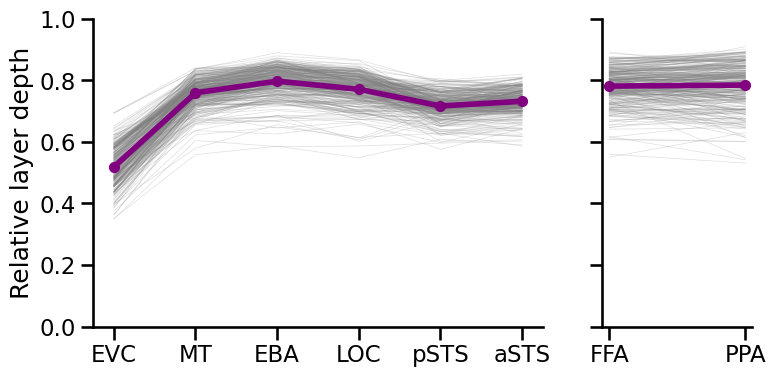

In [12]:
_, axes = plt.subplots(1, 2, figsize=(8.5,4),
                       gridspec_kw={'width_ratios': [3, 1]},
                       sharey=True)
sns.set_palette('mako_r')
color = ['gray', 'gray', 'gray']
unique_model_uids = max_scores['model_uid'].unique()
color_palette = {uid: 'gray' for uid in unique_model_uids}
max_scores_test = max_scores[max_scores.set == 'test']

for i_ax, (ax, cur_rois) in enumerate(zip(axes, [['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS'], ['FFA', 'PPA']])):
    cur_scores = max_scores_test[max_scores_test.roi_name.isin(cur_rois)]
    cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
                                            categories=cur_rois, ordered=True)
    cur_scores_avg = cur_scores.groupby('roi_name').mean(numeric_only=True)

    sns.pointplot(x='roi_name', y='layer_relative_depth', data=cur_scores_avg,
                 marker='.', markersize=10, zorder=1, color='purple',
                 ax=ax, legend=False)
    sns.lineplot(x='roi_name', y='layer_relative_depth', hue='model_uid',
                 data=cur_scores, ax=ax,
                 linewidth=.5, alpha=0.25, zorder=0,
                 legend=False, palette=color_palette)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels, ha='center')
    ax.set_xlabel('')
    ax.set_ylim([0,1])
    if i_ax == 0:
        ax.set_ylabel('Relative layer depth')

## Language Models

### Behavior

In [13]:
files = glob(f'../data/interim/LanguageBehaviorEncoding/*.csv.gz')
print(f'{len(files)} behavioral encoding models found')
df = []
for file in files:
    df.append(pd.read_csv(file))
df = pd.concat(df)

5 behavioral encoding models found


In [14]:
def get_max_score(group, col='train_score'):
    return group.loc[group[col].idxmax()]

In [15]:
max_scores = df.groupby(['feature', 'model_uid']).apply(get_max_score).reset_index(drop=True)
rename_mapping = {orig: orig.replace('rating-', '').replace('_', ' ') for orig in max_scores.feature.unique()}
max_scores = pd.melt(max_scores, id_vars=["model_uid", "model_layer", "model_layer_index", "feature"], 
                    value_vars=["train_score", "test_score"], 
                    var_name="set", value_name="score")
max_scores['feature'] = max_scores['feature'].replace(rename_mapping)
max_scores['feature'] = pd.Categorical(max_scores['feature'], categories=annotated_features, ordered=True)
max_scores['set'] = max_scores['set'].replace({'train_score': 'train', 'test_score': 'test'})
max_scores['set'] = pd.Categorical(max_scores['set'], categories=['train', 'test'], ordered=True)

/tmp/ipykernel_364818/2405867124.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=40, ha='right')


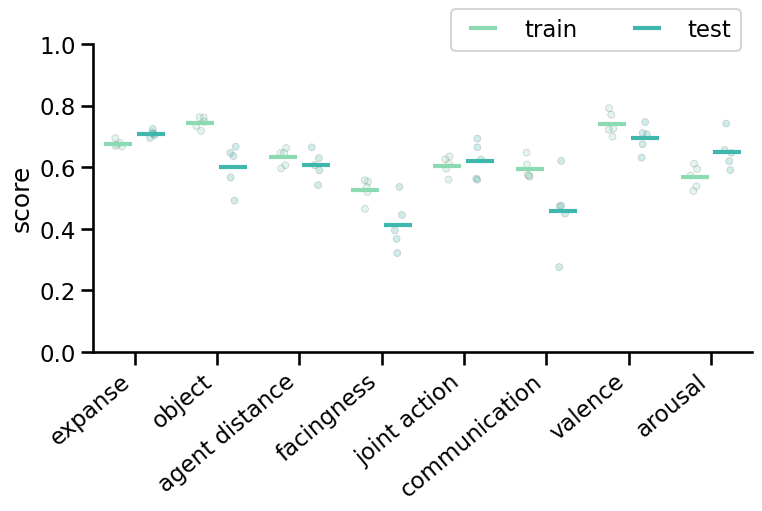

In [16]:
_, ax = plt.subplots(figsize=(8.5,4))
sns.set_palette('mako_r')
color = ['gray', 'gray', 'gray']
# sns.barplot(x='feature', y='score', hue='metric', data=max_scores,
#             ax=ax, dodge=True, errorbar=None, palette=color,legend=False, zorder=0)
sns.stripplot(x='feature', y='score', hue='set', data=max_scores,
              ax=ax, dodge=True, jitter=True, linewidth=.5, alpha=0.25, zorder=0, legend=False)
sns.pointplot(x='feature', y='score', hue='set', data=max_scores,
               dodge=.4, linestyle="none", errorbar=None,
              marker="_", markersize=20, markeredgewidth=3, zorder=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xlabels = ax.get_xticklabels()
ax.set_xlabel('')
ax.set_xticklabels(xlabels, rotation=40, ha='right')
ax.set_ylim([0,1])
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.15),
          ncol=2, fancybox=True)

### Neural

In [17]:
files = glob(f'../data/interim/LanguageNeuralEncoding/*.csv.gz')
print(f'{len(files)} neural encoding models found')
df = []
for file in tqdm(files):
    cdf = pd.read_csv(file)
    df.append(cdf[cdf['roi_name'] != 'none'].reset_index(drop=True))
df = pd.concat(df).reset_index(drop=True)

15 neural encoding models found


100%|██████████| 15/15 [00:04<00:00,  3.01it/s]


In [18]:
max_scores = df.groupby(['subj_id', 'roi_name', 'model_uid']).mean(numeric_only=True).reset_index()
max_scores = max_scores.groupby(['roi_name', 'model_uid']).mean(numeric_only=True).reset_index()
max_scores = max_scores.loc[max_scores.roi_name.isin(rois)].reset_index(drop=True)
max_scores = pd.melt(max_scores, id_vars=["model_uid", "layer_index", "layer_relative_depth", "roi_name", "reliability"], 
                    value_vars=["train_score", "test_score"], 
                    var_name="set", value_name="score")
# max_scores['feature'] = max_scores['feature'].replace(rename_mapping)
max_scores['roi_name'] = pd.Categorical(max_scores['roi_name'], categories=rois, ordered=True)
max_scores['set'] = max_scores['set'].replace({'train_score': 'train', 'test_score': 'test'})
max_scores['set'] = pd.Categorical(max_scores['set'], categories=['train', 'test'], ordered=True)
max_scores['normalized_score'] = max_scores['score'] / max_scores['reliability']

/tmp/ipykernel_364818/3571978288.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/tmp/ipykernel_364818/3571978288.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, ha='center')
/tmp/ipykernel_364818/3571978288.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/tm

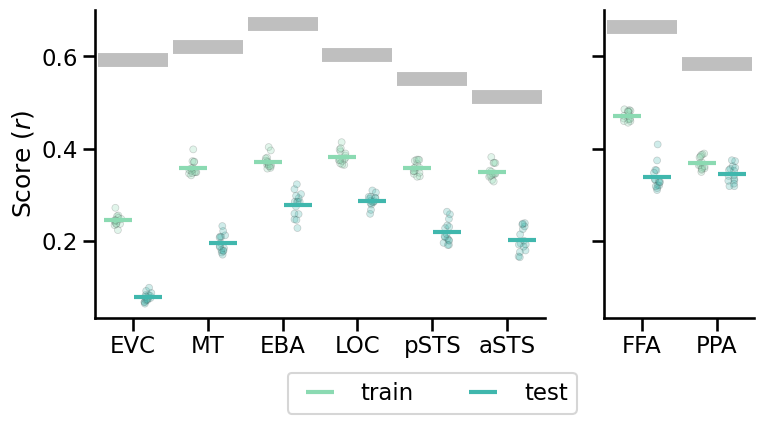

In [19]:
_, axes = plt.subplots(1, 2, figsize=(8.5,4), gridspec_kw={'width_ratios': [3, 1]},
                      sharey=True)
sns.set_palette('mako_r')
color = ['gray', 'gray', 'gray']
for i_ax, (ax, cur_rois) in enumerate(zip(axes, [['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS'], ['FFA', 'PPA']])):
    cur_scores = max_scores.loc[max_scores.roi_name.isin(cur_rois)]
    cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
                                            categories=cur_rois, ordered=True)
    sns.stripplot(x='roi_name', y='score', hue='set', data=cur_scores,
                  ax=ax, dodge=True, jitter=True, linewidth=.5,
                  alpha=0.25, zorder=0, legend=False)
    sns.pointplot(x='roi_name', y='reliability', data=cur_scores,
                  ax=ax, linestyle="none", errorbar=None, 
                  marker="_", markersize=50, markeredgewidth=10,
                  color='gray', alpha=.5, zorder=1)
    if i_ax == 0: 
        sns.pointplot(x='roi_name', y='score', hue='set', data=cur_scores,
                      ax=ax, legend=True, 
                      dodge=.4, linestyle="none", errorbar=None,
                      marker="_", markersize=20, markeredgewidth=3, zorder=1)
    else: 
        sns.pointplot(x='roi_name', y='score', hue='set', data=cur_scores,
                      ax=ax, legend=False,
                      dodge=.4, linestyle="none", errorbar=None,
                      marker="_", markersize=20, markeredgewidth=3, zorder=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels, ha='center')
    ax.set_xlabel('')
    if i_ax == 0: 
        ax.set_ylabel('Score ($r$)')
        ax.legend(loc='lower center', bbox_to_anchor=(0.75, -.35),
                  ncol=2, fancybox=True)

/tmp/ipykernel_364818/873357488.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/tmp/ipykernel_364818/873357488.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, ha='center')
/tmp/ipykernel_364818/873357488.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/tmp/i

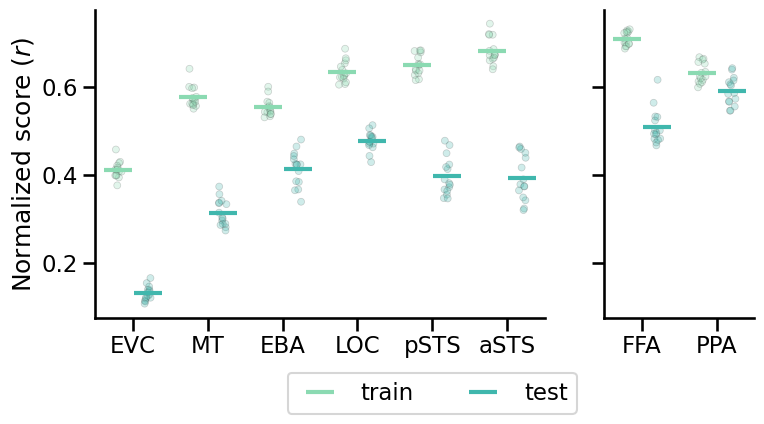

In [20]:
_, axes = plt.subplots(1, 2, figsize=(8.5,4),
                       gridspec_kw={'width_ratios': [3, 1]},
                       sharey=True)
sns.set_palette('mako_r')
color = ['gray', 'gray', 'gray']
for i_ax, (ax, cur_rois) in enumerate(zip(axes, [['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS'], ['FFA', 'PPA']])):
    cur_scores = max_scores.loc[max_scores.roi_name.isin(cur_rois)]
    cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
                                            categories=cur_rois, ordered=True)
    sns.stripplot(x='roi_name', y='normalized_score', hue='set', data=cur_scores,
                  ax=ax, dodge=True, jitter=True, linewidth=.5,
                  alpha=0.25, zorder=0, legend=False)
    if i_ax == 0: 
        sns.pointplot(x='roi_name', y='normalized_score', hue='set', data=cur_scores,
                      ax=ax, legend=True, 
                      dodge=.4, linestyle="none", errorbar=None,
                      marker="_", markersize=20, markeredgewidth=3, zorder=1)
    else: 
        sns.pointplot(x='roi_name', y='normalized_score', hue='set', data=cur_scores,
                      ax=ax, legend=False,
                      dodge=.4, linestyle="none", errorbar=None,
                      marker="_", markersize=20, markeredgewidth=3, zorder=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels, ha='center')
    ax.set_xlabel('')
    if i_ax == 0: 
        ax.set_ylabel('Normalized score ($r$)')
        ax.legend(loc='lower center', bbox_to_anchor=(0.75, -.35),
                  ncol=2, fancybox=True)

/tmp/ipykernel_364818/605010439.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/tmp/ipykernel_364818/605010439.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cur_scores_avg = cur_scores.groupby('roi_name').mean(numeric_only=True)
/tmp/ipykernel_364818/605010439.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, ha='center')
/tmp/ipykernel_364818/605010439.py:12: SettingWi

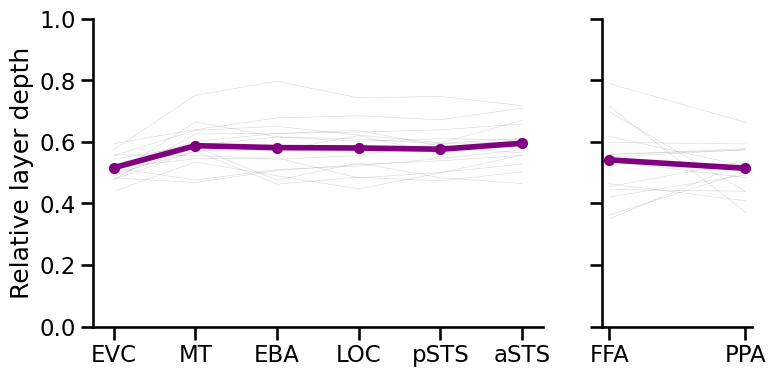

In [21]:
_, axes = plt.subplots(1, 2, figsize=(8.5,4),
                       gridspec_kw={'width_ratios': [3, 1]},
                       sharey=True)
sns.set_palette('mako_r')
color = ['gray', 'gray', 'gray']
unique_model_uids = max_scores['model_uid'].unique()
color_palette = {uid: 'gray' for uid in unique_model_uids}
max_scores_test = max_scores[max_scores.set == 'test']

for i_ax, (ax, cur_rois) in enumerate(zip(axes, [['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS'], ['FFA', 'PPA']])):
    cur_scores = max_scores_test[max_scores_test.roi_name.isin(cur_rois)]
    cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
                                            categories=cur_rois, ordered=True)
    cur_scores_avg = cur_scores.groupby('roi_name').mean(numeric_only=True)

    sns.pointplot(x='roi_name', y='layer_relative_depth', data=cur_scores_avg,
                 marker='.', markersize=10, zorder=1, color='purple',
                 ax=ax, legend=False)
    sns.lineplot(x='roi_name', y='layer_relative_depth', hue='model_uid',
                 data=cur_scores, ax=ax,
                 linewidth=.5, alpha=0.25, zorder=0,
                 legend=False, palette=color_palette)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels, ha='center')
    ax.set_xlabel('')
    ax.set_ylim([0,1])
    if i_ax == 0:
        ax.set_ylabel('Relative layer depth')

## Combined models

### Behavior

In [22]:
files = glob(f'../data/interim/VisionBehaviorEncoding/*.csv.gz')
files += glob(f'../data/interim/LanguageBehaviorEncoding/*.csv.gz')
print(f'{len(files)} behavior encoding models found')
df = []
for file in tqdm(files):
    cdf = pd.read_csv(file)
    if 'Vision' in file:
        cdf['model_class'] = 'vision'
    elif 'Language' in file:
        cdf['model_class'] = 'language'
    df.append(cdf)
df = pd.concat(df)
df.head()

341 behavior encoding models found


100%|██████████| 341/341 [00:01<00:00, 270.87it/s]


,model_uid,model_layer,model_layer_index,feature,train_score,test_score,model_class
0,timm_mvitv2_base,MultiScaleVit,1,rating-expanse,0.689438,0.640602,vision
1,timm_mvitv2_base,MultiScaleVit,1,rating-object,0.465206,0.150855,vision
2,timm_mvitv2_base,MultiScaleVit,1,rating-agent_distance,0.441004,0.405715,vision
3,timm_mvitv2_base,MultiScaleVit,1,rating-facingness,0.149872,-0.072921,vision
4,timm_mvitv2_base,MultiScaleVit,1,rating-joint_action,0.070612,0.031442,vision


In [23]:
max_scores = df.groupby(['feature', 'model_uid']).apply(get_max_score).reset_index(drop=True)
rename_mapping = {orig: orig.replace('rating-', '').replace('_', ' ') for orig in max_scores.feature.unique()}
max_scores['feature'] = max_scores['feature'].replace(rename_mapping)
max_scores['feature'] = pd.Categorical(max_scores['feature'], categories=annotated_features, ordered=True)
max_scores['model_class'] = pd.Categorical(max_scores['model_class'], categories=['vision', 'language'], ordered=True)
max_scores.head()

,model_uid,model_layer,model_layer_index,feature,train_score,test_score,model_class
0,bit_expert_abstraction,PreActBottleneck-3-15,155,agent distance,0.642042,0.578369,vision
1,bit_expert_animal,PreActBottleneck-3-15,155,agent distance,0.654780,0.602911,vision
2,bit_expert_arthropod,PreActBottleneck-3-15,155,agent distance,0.650945,0.592135,vision
3,bit_expert_bird,PreActBottleneck-3-15,155,agent distance,0.661486,0.594789,vision
4,bit_expert_flower,StdConv2d-4-142,168,agent distance,0.657495,0.531701,vision


/tmp/ipykernel_364818/1797316719.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=40, ha='right')


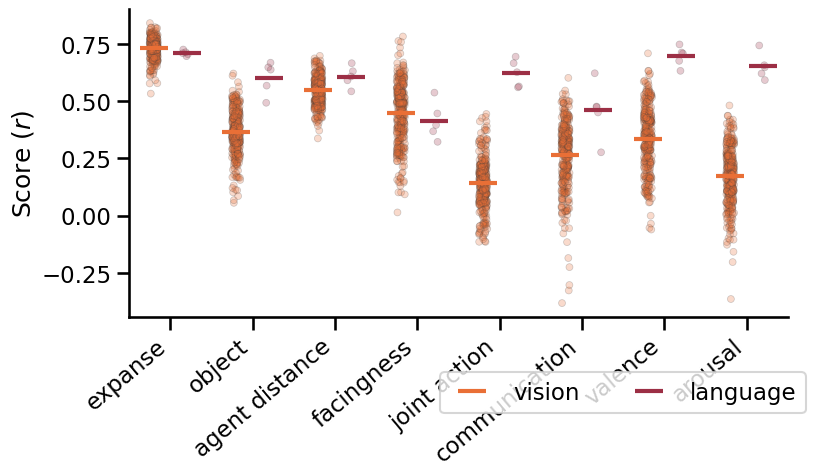

In [24]:
_, ax = plt.subplots(figsize=(8.5,4))
sns.set_palette('icefire_r')
color = ['gray', 'gray', 'gray']
# sns.barplot(x='feature', y='score', hue='metric', data=max_scores,
#             ax=ax, dodge=True, errorbar=None, palette=color,legend=False, zorder=0)
sns.stripplot(x='feature', y='test_score', hue='model_class', data=max_scores,
              ax=ax, dodge=True, jitter=True, linewidth=.5, alpha=0.25, zorder=0, legend=False)
sns.pointplot(x='feature', y='test_score', hue='model_class', data=max_scores,
               dodge=.4, linestyle="none", errorbar=None,
              marker="_", markersize=20, markeredgewidth=3, zorder=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, rotation=40, ha='right')
ax.set_xlabel('')
ax.set_ylabel('Score ($r$)')
ax.legend(loc='lower center', bbox_to_anchor=(0.75, -.35),
          ncol=2, fancybox=True)

### Neural

In [25]:
files = glob(f'../data/interim/VisionNeuralEncoding/*.csv.gz')
files += glob(f'../data/interim/LanguageNeuralEncoding/*.csv.gz')
print(f'{len(files)} neural encoding models found')
df = []
for file in tqdm(files):
    cdf = pd.read_csv(file)
    if 'Vision' in file:
        cdf['model_class'] = 'vision'
    elif 'Language' in file:
        cdf['model_class'] = 'language'
    df.append(cdf[cdf['roi_name'] != 'none'].reset_index(drop=True))
df = pd.concat(df)
df['normalized_score'] = df['test_score'] / df['reliability']
df.head()

343 neural encoding models found


100%|██████████| 343/343 [01:34<00:00,  3.61it/s]


,voxel_id,roi_name,stream_name,subj_id,reliability,i_index,j_index,k_index,layer_index,layer_relative_depth,layer,train_score,model_uid,test_score,model_class,normalized_score
0,108,pSTS,high_lateral,1,0.384594,4,30,36,76,0.189055,Linear-6-57,0.232495,timm_mvitv2_base,0.066880,vision,0.173898
1,237,pSTS,high_lateral,1,0.580704,5,28,36,388,0.965174,Linear-6-330,0.161965,timm_mvitv2_base,0.079379,vision,0.136694
2,238,pSTS,high_lateral,1,0.578962,5,28,37,274,0.681592,Linear-6-232,0.249373,timm_mvitv2_base,0.235356,vision,0.406513
3,239,pSTS,high_lateral,1,0.666494,5,28,38,29,0.072139,LayerNorm-6-21,0.313365,timm_mvitv2_base,0.036749,vision,0.055138
4,244,pSTS,high_lateral,1,0.481124,5,29,36,76,0.189055,Linear-6-57,0.180351,timm_mvitv2_base,0.074278,vision,0.154384


In [26]:
max_scores = df.groupby(['subj_id', 'roi_name', 'model_uid', 'model_class']).mean(numeric_only=True).reset_index()
max_scores = max_scores.groupby(['roi_name', 'model_uid', 'model_class']).mean(numeric_only=True).reset_index()
max_scores = max_scores.loc[max_scores.roi_name.isin(rois)].reset_index(drop=True)

max_scores['model_class'] = pd.Categorical(max_scores['model_class'], categories=['vision', 'language'], ordered=True)
max_scores.head()

,roi_name,model_uid,model_class,subj_id,voxel_id,reliability,i_index,j_index,k_index,layer_index,layer_relative_depth,train_score,test_score,normalized_score
0,EBA,bit_expert_abstraction,vision,2.5,86374.460539,0.671132,34.735076,19.297754,31.940633,146.405376,0.841410,0.386134,0.273734,0.400704
1,EBA,bit_expert_animal,vision,2.5,86374.460539,0.671132,34.735076,19.297754,31.940633,147.104415,0.845428,0.383612,0.279514,0.411135
2,EBA,bit_expert_arthropod,vision,2.5,86374.460539,0.671132,34.735076,19.297754,31.940633,151.805054,0.872443,0.381761,0.276338,0.406460
3,EBA,bit_expert_bird,vision,2.5,86374.460539,0.671132,34.735076,19.297754,31.940633,147.275429,0.846411,0.378614,0.273733,0.400997
4,EBA,bit_expert_flower,vision,2.5,86374.460539,0.671132,34.735076,19.297754,31.940633,138.898290,0.798266,0.385933,0.258232,0.378596


/tmp/ipykernel_364818/2770246759.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/tmp/ipykernel_364818/2770246759.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, ha='center')
/tmp/ipykernel_364818/2770246759.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/

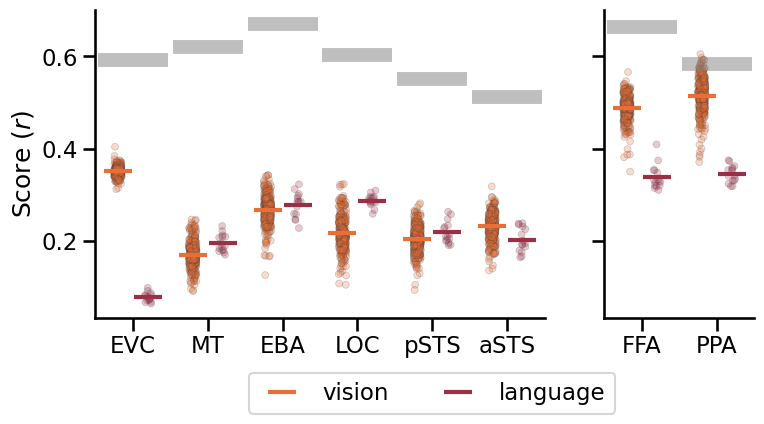

In [27]:
_, axes = plt.subplots(1, 2, figsize=(8.5,4), gridspec_kw={'width_ratios': [3, 1]},
                      sharey=True)
sns.set_palette('icefire_r')
color = ['gray', 'gray', 'gray']
# sns.barplot(x='feature', y='score', hue='metric', data=max_scores,
#             ax=ax, dodge=True, errorbar=None, palette=color,legend=False, zorder=0)
for i_ax, (ax, cur_rois) in enumerate(zip(axes,
                                          [['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS'],
                                           ['FFA', 'PPA']])):
    cur_scores = max_scores[max_scores.roi_name.isin(cur_rois)]
    cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
                                            categories=cur_rois, ordered=True)
    sns.stripplot(x='roi_name', y='test_score', hue='model_class', data=cur_scores,
                  ax=ax, dodge=True, jitter=True, linewidth=.5, alpha=0.25, zorder=0, legend=False)
    sns.pointplot(x='roi_name', y='reliability', data=cur_scores,
              linestyle="none", errorbar=None, color='gray',
              marker="_", markersize=50, markeredgewidth=10,
              alpha=.5, zorder=1, ax=ax)
    if i_ax == 0: 
        sns.pointplot(x='roi_name', y='test_score', hue='model_class',
                      data=cur_scores, legend=True,
                      ax=ax, dodge=.4, linestyle="none", errorbar=None,
                      marker="_", markersize=20, markeredgewidth=3, zorder=1)
    else: 
        sns.pointplot(x='roi_name', y='test_score', hue='model_class',
                      data=cur_scores, legend=False,
                      ax=ax, dodge=.4, linestyle="none", errorbar=None,
                      marker="_", markersize=20, markeredgewidth=3, zorder=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels, ha='center')
    ax.set_xlabel('')
    if i_ax == 0: 
        ax.set_ylabel('Score ($r$)')
        ax.legend(loc='lower center', bbox_to_anchor=(0.75, -.35),
                  ncol=2, fancybox=True)

/tmp/ipykernel_364818/3333875288.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/tmp/ipykernel_364818/3333875288.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, ha='center')
/tmp/ipykernel_364818/3333875288.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
/tm

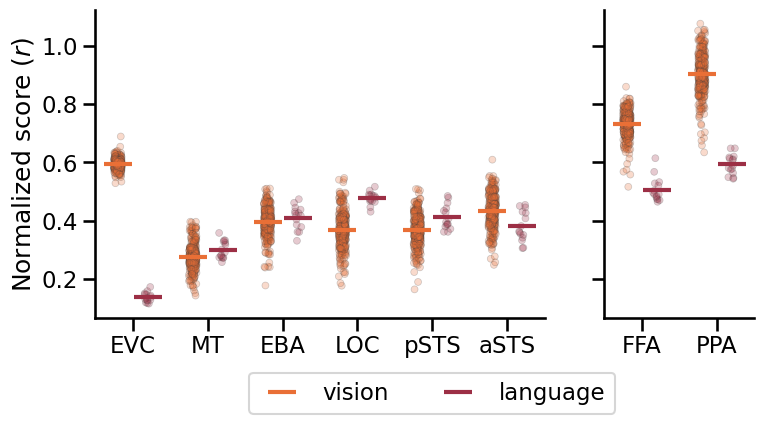

In [28]:
_, axes = plt.subplots(1, 2, figsize=(8.5,4), gridspec_kw={'width_ratios': [3, 1]},
                      sharey=True)
sns.set_palette('icefire_r')
color = ['gray', 'gray', 'gray']
for i_ax, (ax, cur_rois) in enumerate(zip(axes, [['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS'], ['FFA', 'PPA']])):
    cur_scores = max_scores[max_scores.roi_name.isin(cur_rois)]
    cur_scores['roi_name'] = pd.Categorical(cur_scores['roi_name'],
                                            categories=cur_rois, ordered=True)
    sns.stripplot(x='roi_name', y='normalized_score', hue='model_class', data=cur_scores,
                  ax=ax, dodge=True, jitter=True, linewidth=.5, alpha=0.25, zorder=0, legend=False)
    if i_ax == 0: 
        sns.pointplot(x='roi_name', y='normalized_score', hue='model_class',
                      data=cur_scores, legend=True,
                      ax=ax, dodge=.4, linestyle="none", errorbar=None,
                      marker="_", markersize=20, markeredgewidth=3, zorder=1)
    else: 
        sns.pointplot(x='roi_name', y='normalized_score', hue='model_class',
                      data=cur_scores, legend=False,
                      ax=ax, dodge=.4, linestyle="none", errorbar=None,
                      marker="_", markersize=20, markeredgewidth=3, zorder=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels, ha='center')
    ax.set_xlabel('')
    if i_ax == 0: 
        ax.set_ylabel('Normalized score ($r$)')
        ax.legend(loc='lower center', bbox_to_anchor=(0.75, -.35),
                  ncol=2, fancybox=True)